In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize
from matplotlib.colorbar import ColorbarBase
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

import seaborn as sns
import json

from scipy.stats import linregress
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error

from utils import read_data,read_sampled_data

import warnings
warnings.filterwarnings('ignore')

import math

In [2]:
N_list = [n for n in range(7,14)]
problem_name = 'tsp'

In [3]:
idx_list = [i for i in range(48)]
p_list = [1,3,5,7]

In [4]:
def get_path(N,idx):
    return f'distribution/tsp/n{N}/{idx}.npy'

In [5]:
df = read_data(N_list,idx_list,get_path,'gapLB',num_processes=20,resolution=1)
df_density = df[df['r']==1]
df_density['log(opt_density)'] = np.log(df_density['opt_density'])

100%|██████████| 336/336 [00:54<00:00,  6.14it/s] 


In [6]:
def get_path_potp_result(N,p,idx):
    return f'popt_result/tsp/n{N}/p{p}/{idx}.json'

In [7]:
df_sampled = read_sampled_data(N_list,idx_list,p_list,get_path_potp_result,'min',get_path)

1344it [00:03, 340.92it/s]             


In [8]:
def prediction_model(p,N):
    return 2*(2*p+1)**2/math.factorial(N-1)

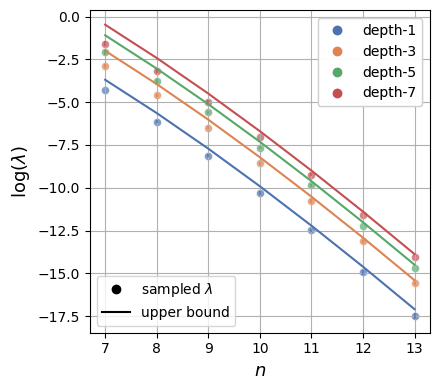

In [9]:
ax = plt.figure(figsize=(4.5, 4))

# 假设 df_sampled, optimized_model 和 params 已经定义好
sample_data = df_sampled
p_list = np.sort(sample_data['depth'].unique()).tolist()
N_list = np.sort(sample_data['N'].unique()).tolist()
palette = sns.color_palette("deep", n_colors=len(p_list))

# 创建一个空的 DataFrame 来存储所有数据
all_data = pd.DataFrame()

# 准备 Sampled 数据和 Fitted Bound 数据
for depth in p_list:
    # Sampled 数据
    temp_data = sample_data[sample_data['depth'] == depth].copy()
    temp_data['$\log(\lambda)$'] = np.log(temp_data['p_opt'])
    temp_data['Type'] = 'Sampled'
    all_data = pd.concat([all_data, temp_data[['N', '$\log(\lambda)$', 'depth', 'Type']]], axis=0)
    
    # Fitted Bound 数据
    fitted_data = pd.DataFrame({
        'N': N_list,
        '$\log(\lambda)$': [np.log(prediction_model(depth, N)) for N in N_list],
        'depth': depth,
        'Type': 'Fitted Bound'
    })
    all_data = pd.concat([all_data, fitted_data], axis=0)

# 绘制图表
# fig, ax = plt.subplots()
depth_handles = []  # 用于存储depth图例的handles

for i, depth in enumerate(p_list):
    # 绘制 Sampled 数据（只有点和误差条）
    sample_depth_data = all_data[(all_data['depth'] == depth) & (all_data['Type'] == 'Sampled')]
    sns.lineplot(x='N', y='$\log(\lambda)$', data=sample_depth_data, marker='o', linestyle='',
                 err_style='bars', color=palette[i], alpha=0.7, label="_nolegend_",zorder=1)

    # 绘制 Fitted Bound 数据（只有线）
    fitted_depth_data = all_data[(all_data['depth'] == depth) & (all_data['Type'] == 'Fitted Bound')]
    sns.lineplot(x='N', y='$\log(\lambda)$', data=fitted_depth_data, color=palette[i], linestyle='-', marker='', label="_nolegend_",zorder=2)

    # 添加具有正确颜色的图例句柄
    depth_handles.append(Line2D([0], [0], marker='o', linestyle='', color=palette[i], lw=2, label=f"depth-{depth}"))

# 添加 Type 图例
type_handles = [Line2D([0], [0], marker='o',linestyle='', color='black', label=r'sampled $\lambda$', lw=2),
                Line2D([0], [0], linestyle='-', color='black', label=r'upper bound')]

# 组合图例
depth_legend = ax.legend(handles=depth_handles, loc='upper right',borderaxespad=1.3)
ax.add_artist(depth_legend)  # Anchor the first legend on the canvas
type_legend = plt.legend(handles=type_handles, loc='lower left')

plt.xlabel(r'$n$',fontsize=13)
plt.ylabel(r'$\log(\lambda)$',fontsize=13)

plt.grid(True)
plt.tight_layout()
plt.savefig(f'figs/{problem_name}_popt.pdf')
plt.show()

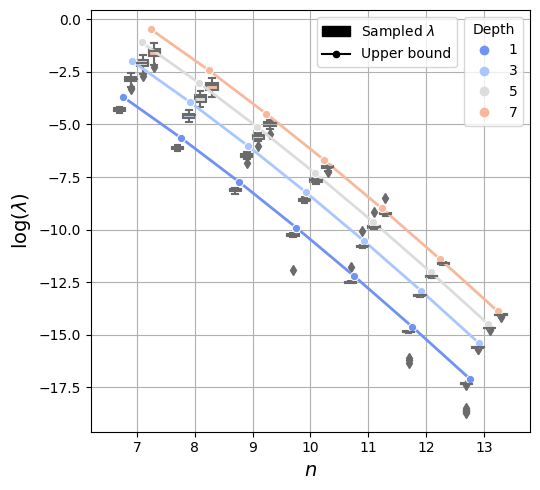

In [33]:
# 假设 df_sampled, optimized_model 和 params 已经定义好
sample_data = df_sampled
p_list = np.sort(sample_data['depth'].unique()).tolist()
N_list = np.sort(sample_data['N'].unique()).tolist()
palette = sns.color_palette("coolwarm", n_colors=5)[:4]

# 创建一个空的 DataFrame 来存储所有数据
all_data = pd.DataFrame()

# 准备 Sampled 数据和 Fitted Bound 数据
for depth in p_list:
    # Sampled 数据
    temp_data = sample_data[sample_data['depth'] == depth].copy()
    temp_data['$\log(\lambda)$'] = np.log(temp_data['p_opt'])
    temp_data['Type'] = 'Sampled'
    all_data = pd.concat([all_data, temp_data[['N', '$\log(\lambda)$', 'depth', 'Type']]], axis=0)
    
    # Fitted Bound 数据
    fitted_data = pd.DataFrame({
        'N': N_list,
        '$\log(\lambda)$': [np.log(prediction_model(depth, N)) for N in N_list],
        'depth': depth,
        'Type': 'Fitted Bound'
    })
    all_data = pd.concat([all_data, fitted_data], axis=0)

# Assuming 'data' is your DataFrame
sampled_data = all_data[all_data['Type'] == 'Sampled']
fitted_data = all_data[all_data['Type'] == 'Fitted Bound']

# Set up the figure for plotting
plt.figure(figsize=(5.5, 5))

# Draw boxplot for sampled data
ax = sns.boxplot(data=sampled_data, x='N', y='$\log(\lambda)$', hue='depth', palette=palette, dodge=True)

# Get positions of boxplots for alignment
dodge_width = 0.8  # Estimated dodge width for boxplots with hues
hue_order = sorted(sampled_data['depth'].unique())
centers = np.arange(len(sampled_data['N'].unique()))  # Center positions for each 'N'

# Overlay corrected line plots for 'Fitted Bound' data
# palette = sns.color_palette("coolwarm", n_colors=len(hue_order))
for i, depth in enumerate(hue_order):
    fitted_subset = fitted_data[fitted_data['depth'] == depth]
    # Calculate adjusted centers for line plots
    adjusted_centers = centers + dodge_width * (i - (len(hue_order) - 1) / 2) * 0.2  # slight shift for centering
    sns.lineplot(x=adjusted_centers, y=fitted_subset['$\log(\lambda)$'], color=palette[i], marker='o', markersize=6, linewidth=2, label=f"{depth}")

# Create custom type legend
type_handles = [
    mpatches.Patch(color='black', label='Sampled $\lambda$'),
    Line2D([0], [0], linestyle='-', marker='o', color='black', markersize=4.5, label='Upper bound')
]
type_legend = ax.legend(handles=type_handles, loc='upper right',bbox_to_anchor=(0.85,1))

# Retrieve handles and labels for depth legend
handles, labels = ax.get_legend_handles_labels()
# depth_handles = handles[len(sampled_data['depth'].unique()):]  # Adjust the slice depending on number of handles
depth_labels = labels[len(sampled_data['depth'].unique()):]  # Adjust the slice depending on number of labels
depth_handles = [Line2D([0], [0], color=palette[i], marker='o', linestyle='', label=f'Depth {depth}') for i, depth in enumerate(hue_order)]
# Create depth legend
depth_legend = ax.legend(handles=depth_handles, labels=depth_labels, title="Depth", loc='upper right')

ax.add_artist(type_legend)  # Add the first legend manually back to the plot

# Enhancing plot details
plt.xlabel('$n$', fontsize=14)
plt.ylabel(r'$\log(\lambda)$', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.savefig(f'figs/comp_popt_{problem_name}.pdf')
# Display the plot
plt.show()

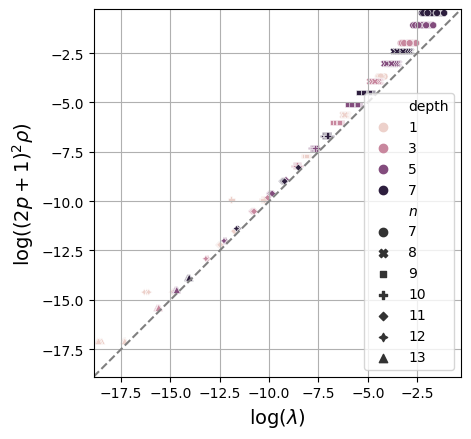

In [18]:
data = df_sampled
data["log(p_opt)"] = np.log(data["p_opt"])
data["log(p_optBound)"] = np.log(data["p_optBound"])
metric1="log(p_opt)"
metric2="log(p_optBound)"
data[r"$n$"] = data['N']

plt.figure(figsize=(4.8,4.8))
sns.scatterplot(data=data, x=metric1, y=metric2, hue="depth", style=r"$n$", alpha=1, s=25)

x_min = data[metric1].min() - 0.2
x_max = data[metric1].max() + 0.2
y_min = data[metric2].min() - 0.2
y_max = data[metric2].max() + 0.2
lim = (min(x_min, y_min), max(x_max, y_max))
plt.xlim(lim)
plt.ylim(lim)
plt.plot(lim, lim, linestyle='--', color='gray')

plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')

plt.xlabel(r'$\log(\lambda)$',fontsize=14)
plt.ylabel(r'$\log((2p+1)^2\rho)$',fontsize=14)
plt.legend(loc='lower right')

plt.tight_layout()
plt.savefig(f'figs/popt_{problem_name}.pdf')
plt.show()